#### Gonna try something epic here

My idea is to create a function/script/ability to overlay a sankey diagram over a bus route to represent the ons/offs and current passenger load, all while being displayed on the map. Hopefully would include hover/tooltip capabilities as well. IDK really how I will start but heres to trying

I will try initially to use the E line to do this. I already have the segment data which will be helpful but the main reason I am using the eline data is that it is mostly straight!! This will help as I am developing for a few reasons.

##### Relevant resources 

https://python-visualization.github.io/folium   ---> folium docs

In [1]:
### Gonna start with the imports. Nothing weird don't freak out.
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely

import folium
import json
import branca.colormap as cm

pd.set_option('display.max_columns', None) ### This line makes all the columns display, rather than ellipses shorten

In [2]:
### import the e line data with segments

kcm_segment_data = "C:/Users/aaron/CoreGIS_Work/CoreGIS Work Sync/COREGIS_work/RapidRide E/Data/Source/Transit_Routes_for_King_County_Metro___transitroute_line"
kcm_point_data = "C:/Users/aaron/CoreGIS_Work/CoreGIS Work Sync/COREGIS_work/RapidRide E/Data/Source/Transit_Stops_for_King_County_Metro___transitstop_point"

all_kcm_segment_data = gpd.read_file(kcm_segment_data)
all_kcm_point_data = gpd.read_file(kcm_point_data)


In [3]:
### gonnna fabricate some data about the ons/offs/avg departing load. This isn't about reflecting reality at the current moment
## Stop list, south to north --> [7690, 7710, 7730, 7750, 7770, 7790, 7810, 7850]

##completely made up
## starting_stop_num: [boardings, alightings]

#type = dict

### E line stops
ridership_data_E = {
    7690: [12, 0],
    7710: [14, 6],
    7730: [13, 2],
    7750: [5, 20],
    7770: [8, 6],
    7790: [10, 14],
    7810: [3, 6],
    7850: [2, 7],
    7880: [1, 6],
    7900: [0, 3]
}



In [4]:
### route 14
ridership_data_14 = {
    11820: [7, 0],
    11840: [3, 3],
    11860: [5, 2],
    11870: [3, 4],
    11880: [2, 1],
    11890: [8, 3],
    11910: [2, 1],
    11920: [1, 3],
    11940: [4, 5],
    8530: [6, 2],
    3600: [3, 4],
    1500: [2, 5],
    1510: [4, 4],
    1530: [1, 2],
    1610: [0, 3],
    538: [8, 4],
    558: [1, 1]
    
 
}

In [5]:
### 8 line stops

ridership_data = {
    2672: [12, 0],
    2180: [13, 6],
    2200: [8, 2],
    2244: [11, 9],
    2245: [0, 3],
    2250: [8, 1],
    2255: [7, 2],
    2260: [8, 3],
    2262: [3, 8],
    2264: [4, 2],
    29268: [3, 7],
    29270: [10, 9]
    
}

In [6]:
### compiling a list of stops that I will use for this experiment. Mostly in a straight line and not too many of them.
#bus_stop_list = [7690, 7710, 7730, 7750, 7770, 7790, 7810, 7850, 7880]
bus_stop_list = list(ridership_data.keys())


stop_geometrys = all_kcm_point_data[all_kcm_point_data['STOP_ID'].isin(bus_stop_list)]
stop_geometrys = stop_geometrys[stop_geometrys['CURRENT_NE'] == 'IN SERVICE'] ## eliminating 3X stops


In [7]:
stop_geometrys.head()

,OBJECTID,CHANGE_NUM,MINOR_CHAN,ACCESSIBIL,ACCESSORY_,STOP_ID,TRANS_LINK,STOP_STATU,STOP_TYPE,AUTH_CODE,AUTH_NAME,TRF_DISTRI,AWNING,BAY_CODE,BEARING_CO,BIKE_RACK,CURB,CURB_HEIGH,CURBPAINT,CURBPAINTL,CURRENT_NE,CF_CROSS_S,CF_DIST_FR,CF_INTERSE,DATE_CREAT,DATE_LAST_,DB_MOD_DAT,DIST_FROM_,EFFECTIVE_,FARE_ZONE,FRDOORLAND,FRDOORSIDE,HASTUS_CRO,IMT_CONNEC,IN_SERVICE,INFOSIGN_A,INFOSIGN,INTERSECTI,JURISDICTI,KCM_MANAGE,XCOORD,XCOORD_OFF,YCOORD,YCOORD_OFF,ZIPCODE,ROUTE_LIST,ON_STREET_,ROUTESIGN,ROUTESIGN_,SIGN_MOUNT,SIGNPOST,SIGNPOST_A,SCHEDULE_H,NUM_SHELTE,GISOBJID,DISPLACEME,geometry
1188,1189,157,8,YES,None,2180,78596,ACT,REG,SEA,Seattle,CB,NO,None,S,NO,UNK,0.0,Unknown,90.0,IN SERVICE,W Harrison St,99.6,FS,1979-05-15,2024-11-19,2024-12-23,99.6,2017-12-02,1,Unknown,0.0,W Harrison St,None,Y,None,Default,Far side,SEA,YES,1264755.8,1264731,230544.6,230545.2,98109,1 13 2 32 8,Queen Anne Ave N,A2 <=6 rts,KCM,Flush,None,Concrete,None,1,215.0,4154.4,POINT (1264731 230545.2)
1191,1192,157,8,YES,None,2200,97411,ACT,REG,SEA,Seattle,CB,NO,None,S,NO,UNK,0.0,YelRed-Stop,127.0,IN SERVICE,W John St,184.7,FM,1981-03-15,2024-11-19,2024-12-23,184.7,2024-07-10,1,Unknown,0.0,W John St,None,Y,None,Default,Far middle,SEA,YES,1264730.7,1264706,229607.9,229608.8,98109,1 13 2 8 D,Queen Anne Ave N,B1 <=12 rts,KCM,Away,2in metal,Base plate,Double,2,216.0,4169.3,POINT (1264706 229608.8)
1247,1248,157,8,YES,None,2244,1918,ACT,REG,SEA,Seattle,CB,NO,None,E,NO,YES,6.0,YelRed-Stop,10.0,IN SERVICE,2nd Ave,280.0,FS,2013-04-23,2024-11-19,2024-12-23,280.0,2023-01-25,1,ADA Access,0.0,2nd Ave,None,Y,None,Default,Far side,SEA,YES,1265967.4,1265967,229336.0,229311.0,98109,1 13 17E 2 24 33 8,Denny Way,B1 <=12 rts,KCM,None,None,None,None,2,100012447.0,280.0,POINT (1265967 229311)
1431,1432,157,8,YES,None,2250,23479,ACT,REG,SEA,Seattle,CB,NO,None,E,NO,UNK,0.0,Unknown,10.0,IN SERVICE,Dexter Ave,35.0,NS,1995-02-11,2024-11-19,2024-12-23,35.0,1995-02-11,1,Unknown,0.0,Dexter Ave,None,Y,None,None,Near side,SEA,YES,1268227.3,1268227,229278.1,229253.1,98109,8,Denny Way,A1 <=2 rts,KCM,Away,2in metal,Concrete,Single,1,226.0,3029.0,POINT (1268227 229253.1)
1432,1433,157,8,YES,None,2255,188559,ACT,REG,SEA,Seattle,CB,NO,None,E,NO,UNK,0.0,Unknown,10.0,IN SERVICE,Westlake Ave,65.0,FS,1995-02-11,2024-11-19,2024-12-23,65.0,1995-02-11,1,Unknown,0.0,Westlake Ave,None,Y,None,None,Far side,SEA,YES,1269293.1,1269293,229250.9,229225.9,98109,8,Denny Way,A1 <=2 rts,KCM,Away,2in metal,Concrete,Single,1,227.0,65.0,POINT (1269293 229225.9)


In [8]:
e_line_full_segment = all_kcm_segment_data[all_kcm_segment_data['ROUTE_NUM'] == 675] ##675 is the E line's route number

In [9]:
#stop_geometrys.explore()

### Ridership data stuffs

In [10]:
### This cell calculates the departing load from every stop!
departing_load = 0

for stop_num in ridership_data.keys():    
    current_boardings = ridership_data[stop_num][0]
    current_alightings = ridership_data[stop_num][1]

    departing_load = departing_load + current_boardings - current_alightings

    ridership_data[stop_num].append(departing_load)
    #print (f"stop_num - {stop_num}, current_boardings - {current_boardings}, current_alightings - {current_alightings}, departing_load - {departing_load}")

### Now its time to try and draw a line between each stop

In [11]:
### make a function enabling the #shortest_line function to work with just two points.

def shortest_line_between(geom1, geom2):
    return gpd.GeoSeries([geom1]).shortest_line(gpd.GeoSeries([geom2])).iloc[0]


In [12]:
## Making sure the stop geometrys data frame is in the proper order
stop_id_ordered_list = list(ridership_data.keys())

id_order = {id_: i for i, id_ in enumerate(stop_id_ordered_list)}
stop_geometrys['Ordered_Ids'] = stop_geometrys['STOP_ID'].map(id_order)

stop_geometrys = stop_geometrys.sort_values('Ordered_Ids')


In [13]:
### generate a *geo* list of stops using the KCM dataset
stop_geometry_dict = {}
for i in range(len(ridership_data.keys())):
    stop_geometry_dict[f"stop_number_{i}_geo"] = stop_geometrys.iloc[i]['geometry']

In [14]:
#create the segments using shortest_line and build the segment_dictionary

num_stops = len(stop_geometry_dict)

segment_dict = {}

for j in range(0, num_stops-1):
    first_stop_loc = stop_geometry_dict[f"stop_number_{j}_geo"]
    second_stop_loc = stop_geometry_dict[f"stop_number_{j+1}_geo"]
    segment_dict[f"segment_{j}"] = shortest_line_between(first_stop_loc, second_stop_loc)

In [15]:
### turn the segment dictionary into a geodataframe
num_segments = len(segment_dict)

segment_gdf = gpd.GeoDataFrame(
                                {'starting_stop_id': bus_stop_list[:num_segments],
                                'ridership_data_dict':[ridership_data[stop_id] for stop_id in bus_stop_list[:num_segments]],
                                'geometry': [segment_dict[f"segment_{id}"] for id in range(num_segments)]},
                                geometry = 'geometry', crs = "EPSG:2926"
                              )


In [16]:
segment_gdf['segment_id'] = range(1, len(segment_gdf) + 1)

print (range(1, len(segment_gdf)))

range(1, 11)


In [17]:
avg_ons_list = []
avg_offs_list = []
avg_load_list = []

for i in range(len(segment_gdf)):
    value_trio = segment_gdf['ridership_data_dict'][i]
    avg_ons_list.append(value_trio[0])
    avg_offs_list.append(value_trio[1])
    avg_load_list.append(value_trio[2])


In [18]:
segment_gdf["boardings"] = avg_ons_list
segment_gdf["alightings"] = avg_offs_list
segment_gdf["departing_load"] = avg_load_list

In [19]:
max_departing_load = segment_gdf['departing_load'].max()

mdl_pct = max_departing_load / 6
step = cm.StepColormap(
    ["#d73027", "#fc8d59", "#fee08b", "#d9ef8b", "#91cf60", "#1a9850",], vmin=0, vmax=max_departing_load, index=[3, mdl_pct, mdl_pct * 2, mdl_pct * 3, mdl_pct * 4, mdl_pct * 5, max_departing_load], caption="step"
)   

In [20]:
def style_function_simple(features):
    departing_load = features["properties"]["departing_load"]
   
    #print (features["properties"]["departing_load"])
    return {
        'weight': departing_load,
        'color': step(departing_load),
        'opacity': 0.8,
        'lineCap': 'butt', # options -> 'round', 'square', 'butt'
        'lineJoin': 'round' #options -> 'round', 'bevel', 'miter'
    }

In [21]:
mainline_tt = folium.GeoJsonTooltip(
    #fields = ['boardings', 'alightings', 'departing_load']
    fields = ['departing_load']
)

In [22]:
##### get the mean position of all the points in the bus stop list.

multipoint_obj = stop_geometrys['geometry'].union_all()

mean_point = multipoint_obj.centroid

centroid_gdf = gpd.GeoDataFrame(geometry=[mean_point], crs = "EPSG:2926")
centroid_gdf = centroid_gdf.to_crs(epsg=4326)
centroid_lat = centroid_gdf.geometry.y
centroid_long = centroid_gdf.geometry.x
#centroid_gdf = gpd.GeoDataFrame(geometry=[mean_point], crs = "EPSG:4326")

In [23]:
stop_geometrys_lat_long = stop_geometrys.to_crs(epsg=4326)

#stop_gdf_lat_long = stop_gdf.to_crs(epsg=4326)

In [24]:
#stop_lat_long_list = [stop_geometrys_lat_long.geometry]

In [25]:
geo_series = stop_geometrys_lat_long.geometry

In [26]:
coord_list = []
for j in geo_series:
    both_coords = (j.y, j.x)
    coord_list.append(both_coords)

In [27]:
coord_list

[(47.62406711673248, -122.35681812266914),
 (47.62184065259279, -122.35683403528067),
 (47.61927266845008, -122.35686022308631),
 (47.618524731799205, -122.35172435560875),
 (47.61851010471927, -122.34788339121029),
 (47.61848789863507, -122.342557910884),
 (47.61847057137016, -122.33823428254003),
 (47.6184681046027, -122.33458024109375),
 (47.61843356523203, -122.33093744651318),
 (47.618432351908616, -122.32744161325273),
 (47.619132670865994, -122.32489053729934),
 (47.619847616701406, -122.3204823697378)]

In [28]:
#folium_map = folium.Map(location=[47.699389, -122.344733], zoom_start=14, tiles="cartodb positron")

folium_map = folium.Map(location=[centroid_lat.item(), centroid_long.item()], zoom_start=13, tiles="cartodb positron")

folium.GeoJson(
    data = segment_gdf,
    style_function = style_function_simple,
    tooltip = mainline_tt
).add_to(folium_map)

In [29]:
folium_map

In [30]:
### turn the segment_gdf into a mulitline??? maybe that will be good??
#segment_gdf.geometry

multi_line = shapely.MultiLineString(list(segment_gdf.geometry))


In [31]:
print(type(multi_line))

<class 'shapely.geometry.multilinestring.MultiLineString'>


In [32]:
segment_gdf.departing_load

0     12
1     19
2     25
3     27
4     24
5     31
6     36
7     41
8     36
9     38
10    34
Name: departing_load, dtype: int64

In [33]:
lats = [tple[0] for tple in coord_list]
lons = [tple[1] for tple in coord_list]

In [34]:
lats

[47.62406711673248,
 47.62184065259279,
 47.61927266845008,
 47.618524731799205,
 47.61851010471927,
 47.61848789863507,
 47.61847057137016,
 47.6184681046027,
 47.61843356523203,
 47.618432351908616,
 47.619132670865994,
 47.619847616701406]

In [35]:

#x = np.linspace(0, 2 * np.pi, 300)

test_positions = list(zip(lats, lons))

line_width = segment_gdf.departing_load.values

m = folium.Map(location=[centroid_lat.item(), centroid_long.item()], zoom_start=13, tiles="cartodb positron")

#color_line = folium.ColorLine(
for i in range (0, len(coord_list) - 1):
    current_segment = [coord_list[i], coord_list[i+1]]
    current_departing_load = int(line_width[i])

    poly_line = folium.PolyLine(
        locations=current_segment,
        #color=segment_gdf.departing_load,
        color = ['#641516'],
        colormap=["y", "orange", "r"],
        #colormap = ['green', 'blue'],
        weight=current_departing_load
    ).add_to(m)

m

In [36]:
#test_map = folium.Map(location=[centroid_lat.item(), centroid_long.item()], zoom_start=13, tiles="cartodb positron")

#location_list = [(47.686890, -122.344507), (47.690616, -122.344550), (47.698562, -122.344744)]

#folium.PolyLine(locations=((47.686890, -122.344507), (47.690616, -122.344550), (47.698562, -122.344744))).add_to(test_map)
#folium.PolyLine(locations=coord_list).add_to(test_map)
#folium.ColorLine(positions=coord_list, colormap=step).add_to(test_map)
#multi_line.add_to(test_map)

In [37]:
#test_map

In [38]:
folium_map

#### Ok now that the single line map is done...... it is time to ***attempt*** to make the boarding/alighting lines

In [39]:
#### use shapely.transform to generate new points?

In [40]:
shifted_stops_dict_alighting = {}
shifted_stops_dict_boarding = {}
counter = 0

alighting_segment_dict = {}
boarding_segment_dict = {}

for point in stop_geometrys['geometry']:
    counter = counter + 1

    ##generate shifted points
    alighting_shifted_point = shapely.transform(geometry=point, transformation=lambda x,y: (x + 700, y + 1000), interleaved=False)
    boarding_shifted_point = shapely.transform(geometry=point, transformation=lambda x,y: (x - 700, y - 1000), interleaved=False)

    ## generate segments using the shifted points
    alighting_segment_dict[f"offshot_segment_{counter}"] = shortest_line_between(point, alighting_shifted_point)
    boarding_segment_dict[f"offshot_segment_{counter}"] = shortest_line_between(point, boarding_shifted_point)
    

alighting_points_list = list(shifted_stops_dict_alighting.values())
boarding_points_list = list(shifted_stops_dict_boarding.values())

In [41]:
alighting_segments_gdf = gpd.GeoDataFrame(geometry = list(alighting_segment_dict.values()), crs = "EPSG:2926")
boarding_segments_gdf = gpd.GeoDataFrame(geometry = list(boarding_segment_dict.values()), crs = "EPSG:2926")

alighting_segments_gdf["associated_starting_stop_id"] = segment_gdf["starting_stop_id"]
alighting_segments_gdf["alightings"] = segment_gdf["alightings"]

boarding_segments_gdf["associated_starting_stop_id"] = segment_gdf["starting_stop_id"]
boarding_segments_gdf["boardings"] = segment_gdf["boardings"]

In [42]:
def boarding_style_function(features):
    boardings = features['properties']['boardings']
    #print (features['properties']['alightings'])
    #print (features['properties']['associated_starting_stop_id'])
    return {
        'weight': boardings,
        'color': '#a913cf',
        'lineCap': 'round', # options -> 'round', 'square', 'butt'
        'lineJoin': 'round' #options -> 'round', 'bevel', 'miter'
    }

In [43]:
boarding_tt = folium.GeoJsonTooltip(
    fields = ['boardings']
)

In [44]:
def alighting_style_function(features):
    alightings = features['properties']['alightings']
    #print (features['properties']['alightings'])
    #print (features['properties']['associated_starting_stop_id'])
    return {
        'weight': alightings,
        'color': '#4978c4',
        'lineCap': 'round', # options -> 'round', 'square', 'butt'
        'lineJoin': 'round' #options -> 'round', 'bevel', 'miter'
    }

In [45]:
alighting_tt = folium.GeoJsonTooltip(
    fields = ['alightings']
)

In [46]:
folium.GeoJson(
    data=alighting_segments_gdf,
    name="alighting_segments",
    style_function=alighting_style_function,
    tooltip = alighting_tt
).add_to(folium_map)

In [47]:
folium.GeoJson(
    data=boarding_segments_gdf,
    name="boarding_segments",
    style_function=boarding_style_function,
    tooltip = boarding_tt
).add_to(folium_map)

In [48]:
folium_map

In [49]:
#folium_map.save('Initial_8_ridership_viz.html') #this line saves the map as an HTML file

### Ok now I have to try to figure out splitting the lines so they can look somewhat appropriate visually

In [50]:
### do I want to make a multiline string for the entire thing??

In [51]:
from shapely.geometry import LineString, MultiLineString
from shapely import ops

# 1. Define the coordinates for the main line and the branches.
# The branching point is where the two segments meet.
main_line = LineString([(0, 0), (5, 5)])
branch1 = LineString([(5, 5), (10, 10)])
branch2 = LineString([(5, 5), (10, 0)])

# 2. Combine the LineString objects into a MultiLineString.
# This represents a network of lines rather than a single, continuous path.
branched_multiline = MultiLineString([main_line, branch1, branch2])

print("Original geometries:")
print(f"Main line: {main_line.wkt}")
print(f"Branch 1: {branch1.wkt}")
print(f"Branch 2: {branch2.wkt}")
print("\nMultiLineString representation of the branched line:")
print(branched_multiline.wkt)

# To visualize this, the individual lines can be plotted separately,
# or you can use `shapely.ops.linemerge()` to simplify them where possible.
merged_lines = ops.linemerge(branched_multiline)
print("\nlinemerge() result (only merges end-to-end lines):")
print(merged_lines.wkt)

Original geometries:
Main line: LINESTRING (0 0, 5 5)
Branch 1: LINESTRING (5 5, 10 10)
Branch 2: LINESTRING (5 5, 10 0)

MultiLineString representation of the branched line:
MULTILINESTRING ((0 0, 5 5), (5 5, 10 10), (5 5, 10 0))

linemerge() result (only merges end-to-end lines):
MULTILINESTRING ((0 0, 5 5), (5 5, 10 10), (5 5, 10 0))


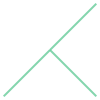

In [52]:
merged_lines

### Seperate attempt

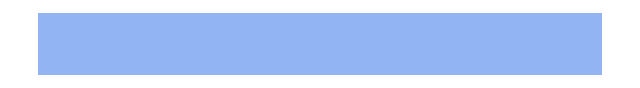

In [53]:

import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.affinity import translate


def make_curve(p1, p2, bulge=0.2, n=5):
    #Create a smooth curve between two points with a given bulge
    x = np.linspace(p1[0], p2[0], n)
    y = np.linspace(p1[1], p2[1], n)
    # bulge using a sine curve
    y += bulge * np.sin(np.linspace(0, np.pi, n))
    return np.column_stack([x, y])

# Main flow (parent)
main = make_curve((0, 2), (0, 3), bulge = 0.5)
#branch1 = make_curve((0, 2), (0, 4), bulge = 0.1)
#branch2 = make_curve((2, 1), (3, 2))
#branch2 = make_curve((2, 1), (3, 0.5), bulge=-0.15)

# Widths
w_main = 10
w1, w2 = 6, 4  # sum = parent width

fig, ax = plt.subplots(figsize=(8, 5))

def draw_flowline(line, width, color):
    #Draw a shapely-like flow line as a filled polygon
    line = LineString(line)
    left = line.parallel_offset(width / 2, 'left', join_style=2)
    right = line.parallel_offset(width / 2, 'right', join_style=2)
    poly_coords = np.vstack([left.coords[:], right.coords[::-1]])
    ax.fill(poly_coords[:,0], poly_coords[:,1], color=color, alpha=0.7, ec='none')

# Draw flows
draw_flowline(main, w_main, 'cornflowerblue')
#draw_flowline(branch1, w1, 'lightgreen')
#draw_flowline(branch2, w2, 'orange')

ax.set_aspect('equal')
ax.axis('off')
plt.show()

In [54]:

from shapely.geometry import Polygon

# Suppose you created flow polygons using shapely above:
flow_polygons = [
    Polygon(np.vstack([left.coords[:], right.coords[::-1]]))
]

gdf = gpd.GeoDataFrame(geometry=flow_polygons, crs="EPSG:4326")

m = folium.Map(location=[0.5, 1.0], zoom_start=5)
folium.GeoJson(gdf.__geo_interface__, style_function=lambda x: {
    "fillColor": "blue", "color": "blue", "fillOpacity": 0.7
}).add_to(m)

#m.save("flow_map.html")

NameError: name 'left' is not defined